# Assignment 6: Neural Networks
**Lauren Enriquez**


## 1. Backpropagation - Essentials

As you examined in class, a simple layer in a feedforward neural network can be expressed as the following:

$$h = Wx + b$$

$$t = \sigma(h)$$

$$\mathcal{L} = \frac{1}{2}(y - t)^2$$

where $x$ is the input, $W$ is the weight matrix at this node, $b$ is the bias added at the node, $\sigma(\cdot)$ is the activation function, $y$ is the label, and $\mathcal{L}$ is the loss.

The activation function and the loss function (squared loss used here) are choices made when creating a neural network. 

### a. What are the unknowns in the problem?

TODO: $ W $ and $b$

### b. What do we want minimize?

TODO: $\mathcal{L} $

### c. What method could we use to find the unknowns?

TODO:  Gradient Descent

### d. Find the partial derivatives of L with respect to the unknowns. 

Assume we use ReLU for the activation function.

TODO:
$$  ∇_WL = 2(y_i - x_iW + b) (-x_i)$$
$$  0 = -2y_ix_i + 2x_i^2W - 2x_ib$$
$$  W = \frac{y_i +b}{x_i} $$


$$  ∇_bL = 2(y_i -x_iW + b)(1) $$
$$ 0 = 2y_i - 2_iW + 2b$$
$$ b = x_iW -y_i $$


## 2. Backpropogation

A neural network is regarded as compositional, in that the output of one layer feeds in as the input to the next layer. Using the the same notation as above but ignoring the bias $b$ for simplicity:

$$t = \sigma_L(W_L \sigma_{L-1}(...\sigma_2(W_2 \sigma_1(W_1x))...))$$

Here $x$ is the original input data, and $t$ is the output of the neural network.

Even more simply, we can look at each layer L:

$$N_1\rightarrow N_2\rightarrow N_3\rightarrow ... N_{L-1}\rightarrow N_L $$

The idea here is the same - we will need to solve for partial derivatives for each layer to set the unknowns. As the previous layer feeds into the next, you can only solve for a Jacobian (vector of partials) one wrt one layer down e.g. we can first solve for

$$ J_{N_L} (N_{L-1})$$

the Jacobian of $N_L$ with respect to $N_{L-1}$

### a. For the above simple representation, write out the Jacobian of the the final layer with respect to the first layer.

TODO: $$ J_{N_L}(N_{L-1}) * J_{N_L-1}(N_{L-2})*  ... * J_{N_3}(N_{2}) * J_{N_2}(N_{1})$$

### b. Based on the equation you've described above, explain using time or space complexity why the best way to solve for the gradient in 2a. is to work backwards.

TODO: The advantage of using backpropagations is because of the use of mathematical derivatives. Is that it is much faster and more precise to calculate than the dot product (used in the feed forward method). This results in less floating point precision problems.

## 3. Simple Neural Network

Here you'll try out writing a neural network for a simple classification problem. For full credit, the final test accuracy should be above 0.6.

The dataset is of cell images from thin blood smear slides of segmented cells, with labels indicating the presence of malaria.

Source: https://lhncbc.nlm.nih.gov/publication/pub9932

Paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6544011/

Some setup to start with:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [2]:
## tf.enable_eager_execution()

In [3]:
malaria, info = tfds.load(name="malaria", split="train", with_info=True)
malaria = malaria.shuffle(30000).prefetch(tf.data.experimental.AUTOTUNE)
info

tfds.core.DatasetInfo(
    name='malaria',
    version=1.0.0,
    description='The Malaria dataset contains a total of 27,558 cell images
with equal instances of parasitized and uninfected cells from the thin blood 
smear slide images of segmented cells.',
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=27558,
    splits={
        'train': 27558,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear images},
      author={Rajaraman, Sivaramakrishnan and Antani, Sameer K and Poostchi, Mahdieh
      and Silamut, Kamolrat and Hossain, Md A and Maude, Richard J and Jaeger, 
      Stefan and Thoma, George R}

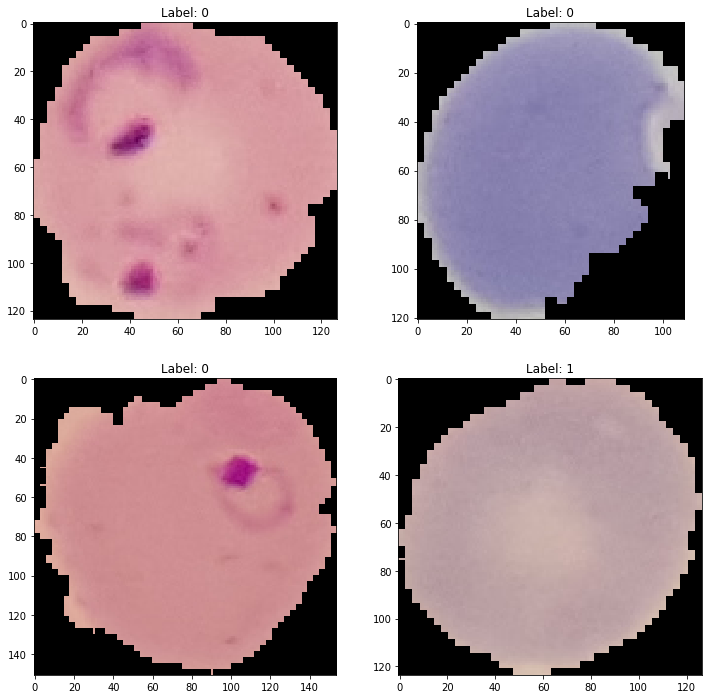

In [4]:
# Visualize some images
plt.figure(figsize=(12,12))

for i, feature in enumerate(malaria.take(4)):
    image = feature["image"].numpy()
    label = feature["label"].numpy()
    
    plt.subplot(2, 2, i+1)
    plt.title("Label: "+str(label))
    plt.imshow(image)
    # i+=1
plt.show()

### a. Extract some samples from the malaria dataset

Hints:

* Keep the total number of samples small ( < 10000) - it largely depends on your memory (if your notebook starts to crash, reduce the number of samples and try again)
* The dimension of each image is height * width * 3, with the 3 representing the number of channels 
* The height and width of the images aren't all the same, so resize all of them to be 133 by 133 (see [tf.image.resize](https://www.tensorflow.org/api_docs/python/tf/image/resize))
* The possibles labels are 0s and 1s (scalars)
* Split into a training and testing set (a split like 80:20 train to test is reasonable)


In [5]:
# TODO: Initialize to the correct shapes with zeros
total_sample_size = 8000
train_size = 0.8
x = int(total_sample_size*train_size)
y = total_sample_size - x

train_images = np.zeros((x,133,133,3))
train_labels = np.zeros(x)
test_images = np.zeros((y,133,133,3))
test_labels = np.zeros(y)

# TODO: Fill in the splits above
for i, feature in enumerate(malaria.take(total_sample_size)):
    image = tf.image.resize(feature["image"],size=[133,133]).numpy()
    label = feature["label"].numpy()
    
    if i < x:
        train_images[i] = image
        train_labels[i] = label
        
    if i >= x:
        test_images[i - x] = image
        test_labels[i - x] = label
    

### b. Add some layers to the model

Hints:

*   See examples of layers in the Keras documentation: https://keras.io/layers/core/
*   For the first layer, provide an input_shape, which refers to the shape of an image from your dataset

See examples at https://www.tensorflow.org/tutorials



https://keras.io/layers/convolutional/

In [53]:
model = keras.Sequential()
# TODO:
model.add(keras.layers.Flatten(input_shape=(133,133,3))) #keep
model.add(keras.layers.Dense(200, activation='relu')) # 200
model.add(keras.layers.Dense(150, activation='relu')) #150
model.add(keras.layers.Dense(8)) #8

### c. Choose how to train the above model

Pick an optimizer, loss function, and metric. If you choose something not covered in class, give a brief explanation and an advantage of your choice.

*   Optimizers: https://keras.io/optimizers/
*   Losses: https://keras.io/losses/
*   Metrics: https://keras.io/metrics/

### Reasoning:

TODO:


In [54]:
# TODO:
opt = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True)
metric = ["accuracy"]

In [55]:
model.compile(optimizer=opt,
              loss=loss_func,
              metrics=metric)

### d. Train the model

Choose an appropriate number of epochs (Hint: try some different values)

In [58]:
# TODO: max 10 when final done
num_epochs = 10

model.fit(train_images, train_labels, epochs=num_epochs)

Train on 6400 samples
Epoch 1/10
6400/6400 [==============================] - 7s 1ms/sample - loss: 4.1685 - accuracy: 0.6253
Epoch 2/10
6400/6400 [==============================] - 7s 1ms/sample - loss: 64.5788 - accuracy: 0.5242
Epoch 3/10
6400/6400 [==============================] - 7s 1ms/sample - loss: 3.1655 - accuracy: 0.5869
Epoch 4/10
6400/6400 [==============================] - 7s 1ms/sample - loss: 1.0977 - accuracy: 0.5900
Epoch 5/10
6400/6400 [==============================] - 7s 1ms/sample - loss: 1.9999 - accuracy: 0.5138
Epoch 6/10
6400/6400 [==============================] - 7s 1ms/sample - loss: 1.3071 - accuracy: 0.5122
Epoch 7/10
6400/6400 [==============================] - 7s 1ms/sample - loss: 1.0097 - accuracy: 0.5300
Epoch 8/10
6400/6400 [==============================] - 7s 1ms/sample - loss: 0.7452 - accuracy: 0.6142
Epoch 9/10
6400/6400 [==============================] - 7s 1ms/sample - loss: 0.6631 - accuracy: 0.6338
Epoch 10/10
6400/6400 [==================

### e. Evaluate based on the testing set

Must be greater that 0.6 for full credit

In [59]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

1600/1600 - 0s - loss: 0.6435 - accuracy: 0.6438

Test accuracy: 0.64375


### f. Based on the above accuracies between the testing and training sets, did you overfit while training?

TODO: **No**, there was not overfit while training. In the end, at the 10th epoch, the validation accuracy is **not significantly less** than the training accuracy (3.90664% difference).


### g. (Extra Credit) Improve your model to achieve an accuracy of greater than 0.75 on the testing set.

In [81]:
#PLAYING AROUND TO GET ABOVE 0.75
model = keras.Sequential()
# TODO:
model.add(keras.layers.Conv2D(16,(4,4), input_shape=(133,133,3), activation = 'relu', padding = "same"))
model.add(keras.layers.Flatten(input_shape=(133,133,3)))
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dense(8))

In [82]:
# TODO:
opt = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True)
metric = ["accuracy"]

In [83]:
model.compile(optimizer=opt,
              loss=loss_func,
              metrics=metric)

In [84]:
# TODO: max 10 when final done
num_epochs = 10

model.fit(train_images, train_labels, epochs=num_epochs)

Train on 6400 samples
Epoch 1/10
6400/6400 [==============================] - 73s 11ms/sample - loss: 222.7965 - accuracy: 0.6870
Epoch 2/10
6400/6400 [==============================] - 69s 11ms/sample - loss: 6.6091 - accuracy: 0.8461
Epoch 3/10
6400/6400 [==============================] - 68s 11ms/sample - loss: 2.7247 - accuracy: 0.9084
Epoch 4/10
6400/6400 [==============================] - 68s 11ms/sample - loss: 1.7237 - accuracy: 0.9320
Epoch 5/10
6400/6400 [==============================] - 69s 11ms/sample - loss: 1.0485 - accuracy: 0.9544
Epoch 6/10
6400/6400 [==============================] - 73s 11ms/sample - loss: 0.6856 - accuracy: 0.9694
Epoch 7/10
6400/6400 [==============================] - 68s 11ms/sample - loss: 0.3547 - accuracy: 0.9802
Epoch 8/10
6400/6400 [==============================] - 69s 11ms/sample - loss: 0.4274 - accuracy: 0.9800
Epoch 9/10
6400/6400 [==============================] - 69s 11ms/sample - loss: 4.8822 - accuracy: 0.8306
Epoch 10/10
6400/6400 

In [85]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

1600/1600 - 4s - loss: 9.0198 - accuracy: 0.7850

Test accuracy: 0.785


### h. (Extra Credit cont.) Based on the above accuracies between the testing and training sets, did you overfit while training?

TODO: **Yes**, there was overfit while training. The accuracy of the data starts to decline at the 8th - 10th epochs. In the end, at the 10th epoch, the validation accuracy is **way less** than the training accuracy (19.6439% difference).